### Components and Residuals
- components : series = trend + seasons + cycles + error
1. learn the trend and subtract it out from the series
2. learn the seasonality from the detrended residuals and subtract the seasons out
3. learn the cycles and subtract the cycles out
4. finally only the unpredictable error remains
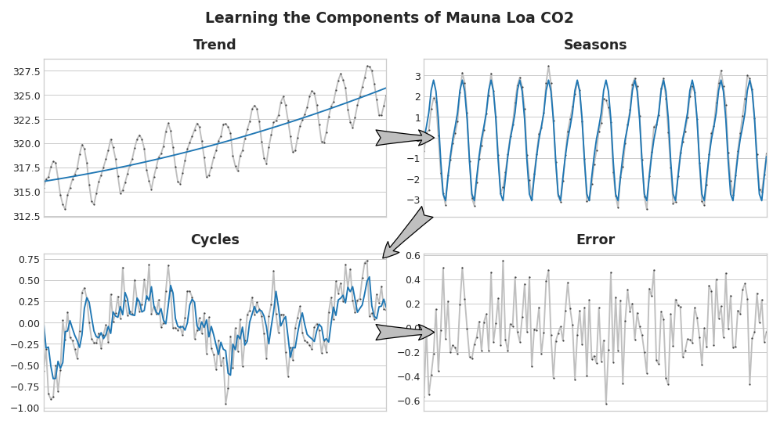

### Hybrid Forecastig with Residuals
- to use one algorithm for some of the components and another algorithm for the rest

1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

단한 학습 알고리즘(보통 선형 회귀)과 복잡한 비선형 학습기(예: GBDT나 심층 신경망)를 순차적으로 사용하는 것입니다.

### Designing Hybrids
- 회귀 알고리즘이 예측을 수행하는 두 가지 방법
    - 특징 변환(Feature-transforming) 알고리즘 : 특징을 입력으로 받아 이를 결합 및 변환하여 목표 값과 일치하는 출력을 생성합니다. 선형 회귀와 신경망이 이에 해당합니다.
    - 목표 변환(Target-transforming) 알고리즘 : 특징을 사용하여 훈련 세트의 목표 값을 그룹화하고, 그룹 내 값을 평균하여 예측합니다. 의사결정 나무와 최근접 이웃이 이에 해당합니다.
    
- 추세 예측: 선형 회귀를 사용하여 추세를 외삽합니다.
- 잔차 예측: 목표 값을 변환하여 추세를 제거한 후, XGBoost와 같은 복잡한 알고리즘을 사용하여 잔차를 예측합니다.

- 잔차에 맞추기 (Boosted Hybrids): 선형 회귀로 추세를 예측하고 잔차를 계산한 후, XGBoost를 사용하여 잔차를 예측합니다.

- 예측을 특징으로 사용하기 (Stacked Hybrids): 다른 모델의 예측 값을 신경망의 입력 특징으로 사용합니다.

In [7]:
# In addition to creating a linear regression + XGBoost hybrid, we'll also see how to set up a time series dataset for use with XGBoost

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    "./csv/us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

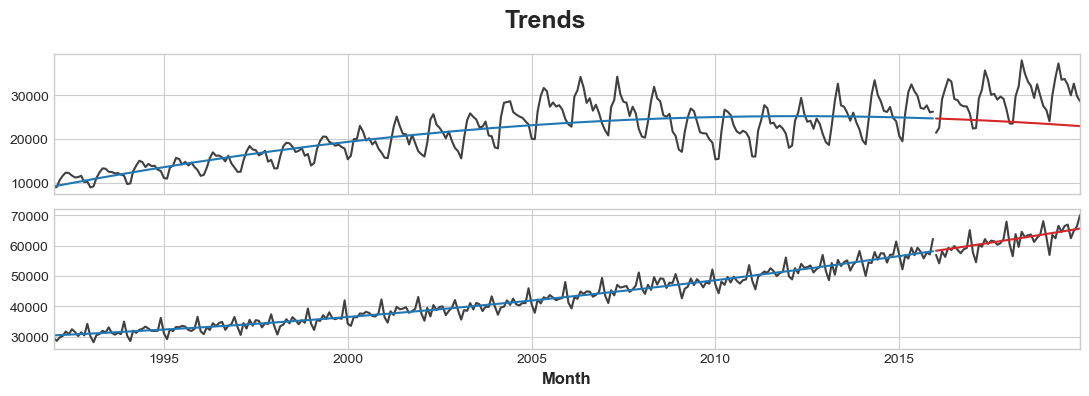

In [8]:
#use a linear regression model to learn the trend in each series
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


In [9]:
#To predict multiple series at once with XGBoost, we'll instead convert these series from side format
# The `stack` method converts column labels to row labels, pivoting from wide format to long

X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [10]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

X

,Industries,Month
Month,,
1992-01-01,0,1
1992-01-01,1,1
1992-02-01,0,2
1992-02-01,1,2
1992-03-01,0,3
...,...,...
2019-10-01,1,10
2019-11-01,0,11
2019-11-01,1,11


In [11]:
#That will give us detrended (residual) series that XGBoost can learn

# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

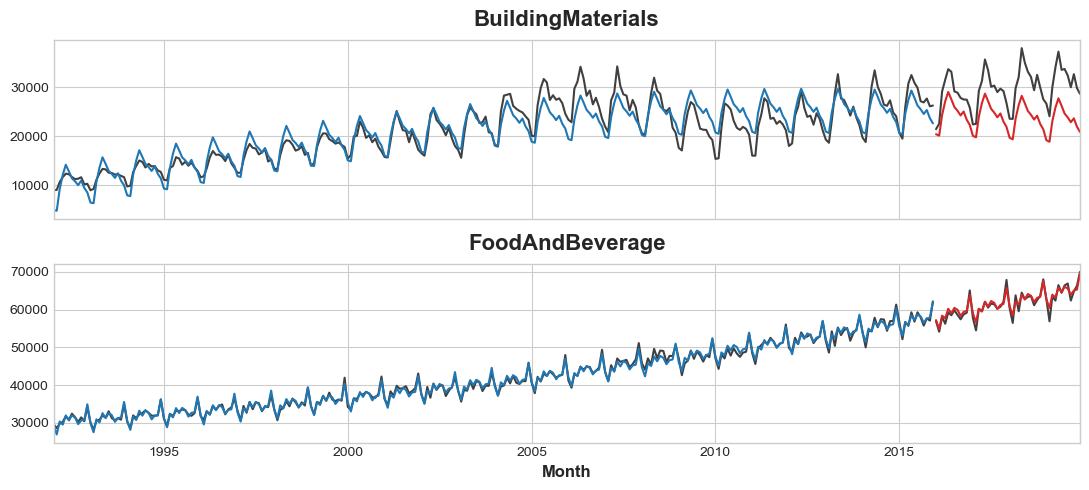

In [12]:
# xgboost 사용한거 나쁘지는 않은데 선형회귀에만 의존하는 경향 큼(BuildingMaterials는 잘 맞추지 못함)
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])
    
    